In this notebook, we use `scipy.signal.find_peaks` peak finder algorithm to determine the false trigger rate of the BBHnet. 

In [1]:
import os
import h5py
import glob

import numpy as np
import scipy.signal as sig
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from gwpy.timeseries import TimeSeries
from gwpy.table import EventTable

%matplotlib inline

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['figure.facecolor']  = 'w'
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [2]:
# Define some constants
# GPS time of confirmed GW in August 2017
event_tc = [1186302519.8, 1186741861.5, 1187058327.1, 1187529256.5]
event_names = ['GW170809', 'GW170814', 'GW170818', 'GW170823']

# Path to directory with NN output
output_dir = '/home/tri.nguyen/gcp_data/hepcloud-output-jobsplit-full/'

Because the background of the LIGO detectors is non-stationary (changing as a function of time), before applying the peak finder algorithm to the output of the neural network, we will fit and subtract a linear background over each frame.

To find the background, we first fit a linear function using `numpy.polyfit` over the output. We then calculate the normalized errors of the fit for each sample and exclude sample with more than `error_threshold=5`. We repeat this step for `n_iterations=10` or until the sample size is less than half of the original sample size.

In [3]:
def fit_background(t, data, error_threshold=5, n_iterations=10):
    ''' return best fit of background '''
    x = t - t[0]
    y = data
    N_total = len(y)
    
    best_fits = None
    for i in range(n_iterations):
        # get best fit
        best_fits = np.polyfit(x, y, 1)

        # compute fit stdv to exclude outlier
        y_pred = best_fits[0] * x + best_fits[1]
        sigma = np.sqrt(np.sum((y - y_pred)**2)) / len(y)
        norm_error = (y - y_pred) / sigma
        
        # update selection
        selection = np.abs(norm_error) <= error_threshold
        x = x[selection]
        y = y[selection]
        
        # break loop if too few samples
        if len(y) < N_total / 2:
            break

    return best_fits

def transform(t, data):
    ''' post-processing function '''
    
    # fit and subtract background
    best_fits = fit_background(t, data)
    background = (t - t[0]) * best_fits[0] + best_fits[1]
    
    return data - background

After subtracting the background, we apply `scipy.signal.find_peaks` to the processed output. Because the neural network takes an input size of 1 second, we restrict the width of the triggers from 0.95 to 1.05 seconds. This accounts for edge effect and excldues triggers caused by glitches.

As an example, we will apply our analysis algorithm (background subtraction + peak finder) to the output frame containing GW170809, a confirmed GW detection.

In [4]:
# Define some output and peak finder parameters
num_jobs = 18  # number of mini jobs

# GPS trigger time and name of GW170809
tc = event_tc[0]
name = event_names[0]

# Loop over all output files and get the frame containing GW170809
for i_job in range(num_jobs):
    
    output_files = sorted(glob.glob(os.path.join(
        output_dir, 'dt-0.0/{}/out/*.hdf5'.format(i_job))))
    
    for output_file in output_files:
        with h5py.File(output_file, 'r') as f:
            # read in gps time of frame
            t_start = f['GPSstart'][0]
            t_stop = f['GPSstart'][-1]
            
            # if the frame contains GW170809
            if (t_start < tc) & (tc < t_stop):
                
                print('Found queried event in {}'.format(output_file))

                # get data and apply background subtraction
                t = f['GPSstart'][:]
                output = f['out'][:].ravel()
                output = transform(t, output)
                
                break

Found queried event in /home/tri.nguyen/gcp_data/hepcloud-output-jobsplit-full/dt-0.0/5/out/out_1186301952-1024.hdf5


In [5]:
# Apply peak finder to the output
sample_rate = 16  # sample rate of network output
min_height = 20  # minimum height of trigger above background
min_width = 0.95 * sample_rate
max_width = 1.05 * sample_rate
triggers, _ = sig.find_peaks(output, height=min_height, width=(min_width, max_width))

# Print out all triggers
print(triggers)

[9080]


The peak finder algorithm found 1 trigger in the frame. We want to check if this trigger coincides with GW170809.

In [6]:
# simply compare the GPS time GW170809 and trigger
print('Trigger time : {:.1f}'.format(t[triggers][0]))
print('GW170809 time: {:.1f}'.format(tc))
print('Difference: {:.1f} seconds'.format(np.abs(tc - t[triggers][0])))

Trigger time : 1186302519.5
GW170809 time: 1186302519.8
Difference: 0.3 seconds


We see that the trigger found coincides with GW170809. Our neural network and detection pipeline have successfully detect GW170809! For visualization purposes, we will plot the output time series and mark all the triggers detected.

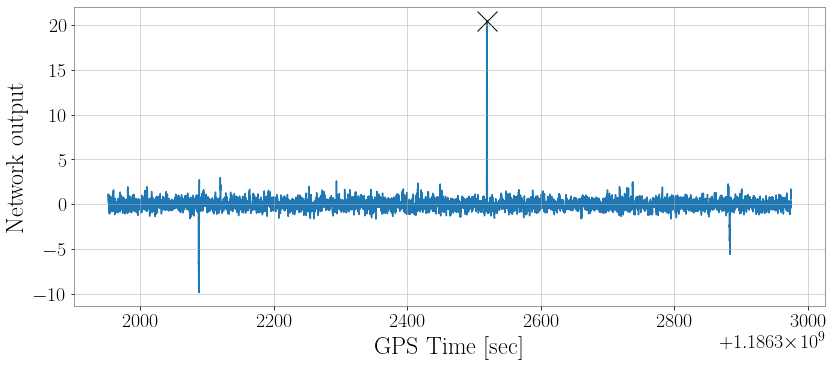

In [7]:
# Plot frame and trigger
fig, ax = plt.subplots(1, figsize=(12, 5.5))

ax.plot(t, output)
ax.plot(t[triggers], output[triggers], 'x', color='k', ms=20, lw=10)
ax.set_xlabel('GPS Time [sec]')
ax.set_ylabel('Network output')

fig.tight_layout()

Indeed, the network output for GW170809 stands out among the rest of the background. We see that the network also detect some glitches (i.e. transient noise) based on the negative score.

For our next example, we consider the 0-lag data. We will calculate the false alarm rate (FAR) in unit of $\mathrm{yr}^{-1}$ as a function of minimum trigger height. As the minimum trigger height *increases*, we will expect the neural network to trigger *less often* on glitches and other noises.

In [8]:
# Define some peak finder parameters
# same with above, but we vary the minimum height instaed
sample_rate = 16  # sample rate of network output
min_width = 0.95 * sample_rate
max_width = 1.05 * sample_rate
min_heights = np.arange(0., 30., 0.5)

# We will keep track of the number of triggers per min height
# in addition, we will also keep track of the total analysis time
num_triggers = np.zeros_like(min_heights)
T_analysis = 0

# Loop over all output files and get the frame containing GW170809
for i_job in range(num_jobs):
    
    output_files = sorted(glob.glob(os.path.join(
        output_dir, 'dt-0.0/{}/out/*.hdf5'.format(i_job))))
    
    for output_file in output_files:
        with h5py.File(output_file, 'r') as f:
            # read in gps time of frame
            t_start = f['GPSstart'][0]
            t_stop = f['GPSstart'][-1]
            
            # we want to check if there is a confirmed GW in the frame
            # we will ignore those frame
            has_event = False
            for name, tc in zip(event_names, event_tc):
                if (t_start < tc) & (tc < t_stop):
                    print('Found {} event in {}'.format(name, output_file))
                    has_event = True
            if has_event:
                continue
            
            # If there is no event
            # get data and apply background subtraction
            t = f['GPSstart'][:]
            output = f['out'][:].ravel()
            output = transform(t, output)
     

            # use scipy.signal.find_peaks to find triggers
            # count number of triggers as a function of the trigger height
            for i, height in enumerate(min_heights):
                triggers, _ = sig.find_peaks(
                    output, height=height, width=(min_width, max_width))
                num_triggers[i] += len(triggers)
            
            # also keep track of live time
            T_analysis += t_stop - t_start

# convert livetime from seconds to years
T_analysis /= 3.154e+7  

Found GW170809 event in /home/tri.nguyen/gcp_data/hepcloud-output-jobsplit-full/dt-0.0/5/out/out_1186301952-1024.hdf5
Found GW170814 event in /home/tri.nguyen/gcp_data/hepcloud-output-jobsplit-full/dt-0.0/8/out/out_1186741248-1024.hdf5
Found GW170818 event in /home/tri.nguyen/gcp_data/hepcloud-output-jobsplit-full/dt-0.0/11/out/out_1187057664-1024.hdf5
Found GW170823 event in /home/tri.nguyen/gcp_data/hepcloud-output-jobsplit-full/dt-0.0/15/out/out_1187528704-1024.hdf5


Plot the FAR, defined as the number of triggers divided by the total analysis time, as a function of the minimum trigger height.

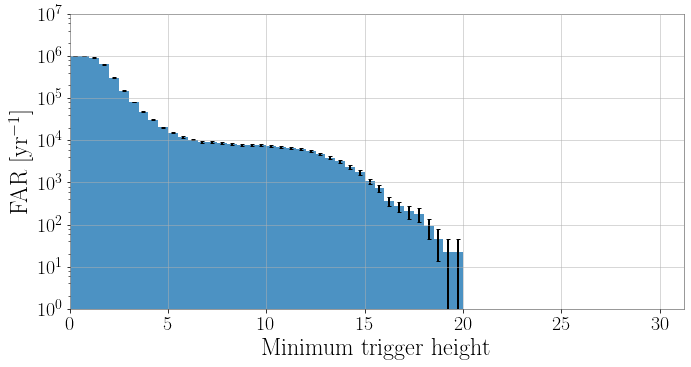

In [9]:
fig, ax = plt.subplots(1, figsize=(10, 5.5))

FAR = num_triggers/T_analysis 
error_FAR = np.sqrt(num_triggers) / T_analysis

# plot FAR with error bar
ax.hist(min_heights, min_heights[:-1], weights=FAR, alpha=0.8)
ax.errorbar(min_heights + 0.25, FAR, yerr=error_FAR, 
            fmt='.', color='k', markersize=0, capsize=2, lw=2)

ax.set_xlabel('Minimum trigger height')
ax.set_ylabel(r'FAR $[\mathrm{yr}^{-1}]$')
ax.set_yscale('log')
ax.set_ylim(1, 1e7)
ax.set_xlim(0, 30)

# format ticker
locmaj = mpl.ticker.LogLocator(base=10, numticks=12) 
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2,0.4,0.6,0.8), numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

fig.tight_layout()

According to the figure, at the minimum trigger height of 20, we expect to see about 20-30 false triggers per year. This is not too bad. 

In order to get the tail of the distribution, we need to run over a longer duration of data. For that, we will run our background subtraction + peak finder algorithm over all 600 timeslides, including the 0-lag data. The code block below will do just that. Since there are lots of data, it will run for a much longer time (about 1-2 hours).

In [10]:
# Define some peak finder parameters
# same with above, but we vary the minimum height instaed
sample_rate = 16  # sample rate of network output
min_width = 0.95 * sample_rate
max_width = 1.05 * sample_rate
min_heights = np.arange(0., 30., 0.5)

# Define timeslides and directory
timeslides = np.arange(0., 300, 0.5)
triggers_output_dir = 'false_alarm_triggers'

os.makedirs(triggers_output_dir, exist_ok=True)

# Loop over all timeslides
for i, tslide in enumerate(timeslides):
    
    # Print out every 10% done
    if i % 60 == 0:
        print('Progress: {:}%'.format(int(i / 600 * 100)))
    
    # Ignore if output file already exists
    triggers_output_file = os.path.join(
        triggers_output_dir, 'rate-{:.1f}.hdf5'.format(tslide))
    if os.path.exists(triggers_output_file):
        continue

    # Similarly to above, for each timeslide, we keep track of the number of triggers 
    # and total analysis time
    num_triggers = np.zeros_like(min_heights)
    T_analysis = 0
    
    # Loop over all output files and get the frame containing GW170809
    for i_job in range(num_jobs):

        # Similarly to above, but with the timeslide as a parameter
        output_files = sorted(glob.glob(os.path.join(
            output_dir, 'dt-{:.1f}/{}/out/*.hdf5'.format(tslide, i_job))))

        for output_file in output_files:
            with h5py.File(output_file, 'r') as f:
                # read in gps time of frame
                t_start = f['GPSstart'][0]
                t_stop = f['GPSstart'][-1]

                # we want to check if there is a confirmed GW in the frame
                # we will ignore those frame
                has_event = False
                for name, tc in zip(event_names, event_tc):
                    if (t_start < tc) & (tc < t_stop):
                        has_event = True
                if has_event:
                    continue

                # If there is no confirmed GW event
                # get data and apply background subtraction
                t = f['GPSstart'][:]
                output = f['out'][:].ravel()
                output = transform(t, output)

                # use scipy.signal.find_peaks to find triggers
                # count number of triggers as a function of the trigger height
                for i, height in enumerate(min_heights):
                    triggers, _ = sig.find_peaks(
                        output, height=height, width=(min_width, max_width))
                    num_triggers[i] += len(triggers)

                # also keep track of live time
                T_analysis += t_stop - t_start

        # convert livetime from seconds to years
        T_analysis /= 3.154e+7  

    # We store output file in HDF5 format for each timeslide
    with h5py.File(triggers_output_file, 'w') as f:
        f.create_dataset('min_heights', data=min_heights)
        f.create_dataset('num_triggers', data=num_triggers)
        f.attrs.update({
            'T_analysis': T_analysis
        })

Progress: 0%
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%


Once this is done, for each minimum height, we add the number of false triggers of each timeslide together, and plot the FAR v. minimum height similarly to above.

In [11]:
# Read in trigger output
num_triggers = np.zeros_like(min_heights)
T_analysis = 0
for tslide in timeslides:
    triggers_output_file = os.path.join(
        triggers_output_dir, 'rate-{:.1f}.hdf5'.format(tslide))
    with h5py.File(triggers_output_file, 'r') as f:
        T_analysis += f.attrs['T_analysis']
        num_triggers += f['num_triggers'][:]

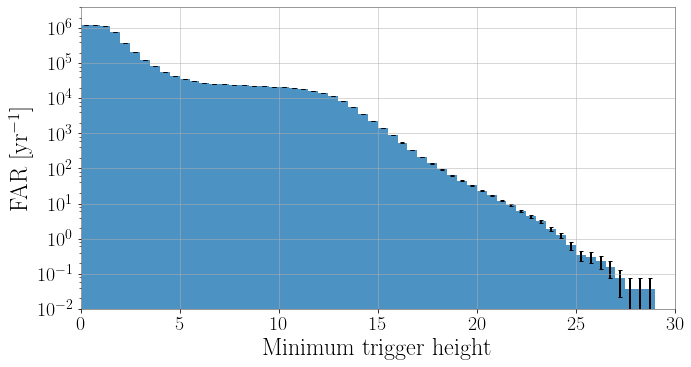

In [12]:
fig, ax = plt.subplots(1, figsize=(10, 5.5))

# plot FAR with error bar
FAR = num_triggers/T_analysis 
error_FAR = np.sqrt(num_triggers) / T_analysis

ax.hist(min_heights, min_heights[:-1], weights=FAR, alpha=0.8)
ax.errorbar(min_heights + 0.25, FAR, yerr=error_FAR, 
            fmt='.', color='k', markersize=0, capsize=2, lw=2)
ax.set_xlabel('Minimum trigger height')
ax.set_ylabel(r'FAR $[\mathrm{yr}^{-1}]$')
ax.set_yscale('log')
ax.set_ylim(1e-2, 4e6)
ax.set_xlim(0., 30)

# format ticker
locmaj = mpl.ticker.LogLocator(base=10, numticks=12) 
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2,0.4,0.6,0.8), numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

fig.tight_layout()